In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ZF-HD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn015051,MEMKGQQGSLGYNNEPIFRETSETLDRHHHLLEQNSPTTTRRPNQD...,262,1
1,Achn041581,MEFDEHEEQEEETGIQVQANYDTAVAGNSGRPKMGGGGEAAALRRG...,233,1
2,Achn074571,MIHHGPAPVPHNHIIVPNLAPQVPSNGSTPTALDLEDHVPYKKMVR...,267,1
3,Achn121961,MKKHQVVVRKNGSNRGVGNSSVASGVRYVECQKNHAANIGGYAVDG...,132,1
4,Achn121971,MSDIKEDAVNKDCSNATSTVQTTNIRYEDCRKNHGARMGKHATDGC...,170,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1936,0.015831,0.002639,0.000000,0.002639,0.000000,0.002639,0.000000,0.00000,0.002639,0.002639,...,0.007916,0.002639,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
3604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004149,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.004149,0.004149,0.0,0.000000,0.0,0.00000
2988,0.002283,0.002283,0.000000,0.002283,0.000000,0.004566,0.000000,0.00000,0.004566,0.000000,...,0.000000,0.006849,0.0,0.002283,0.002283,0.000000,0.0,0.000000,0.0,0.00000
3442,0.017677,0.000000,0.012626,0.015152,0.002525,0.012626,0.000000,0.00000,0.000000,0.005051,...,0.002525,0.000000,0.0,0.002525,0.000000,0.000000,0.0,0.002525,0.0,0.00000
3952,0.001010,0.000000,0.003030,0.007071,0.001010,0.002020,0.003030,0.00202,0.006061,0.005051,...,0.000000,0.001010,0.0,0.001010,0.004040,0.000000,0.0,0.000000,0.0,0.00202


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4122, 441)
X_test: (1031, 441)
y_train: (4122,)
y_test: (1031,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.5625 - loss: 0.6929

34/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6750   

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6768 - loss: 0.6309 - val_accuracy: 0.9709 - val_loss: 0.0868


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1092

35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.0967

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.0921 - val_accuracy: 0.9830 - val_loss: 0.0444


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0140

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0487

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0488 - val_accuracy: 0.9891 - val_loss: 0.0400


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0175

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0301

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0321 - val_accuracy: 0.9915 - val_loss: 0.0242


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0397

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0270

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0249 - val_accuracy: 0.9915 - val_loss: 0.0241


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0122

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0204

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0175 - val_accuracy: 0.9939 - val_loss: 0.0309


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0049

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0212

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0208 - val_accuracy: 0.9927 - val_loss: 0.0278


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0043

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9891 - val_loss: 0.0376


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0146

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0070

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0068 - val_accuracy: 0.9891 - val_loss: 0.0491


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0056

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0068 - val_accuracy: 0.9830 - val_loss: 0.0572


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0179

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0066 - val_accuracy: 0.9915 - val_loss: 0.0434


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0793e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0021    

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.9927 - val_loss: 0.0370


Epoch 13/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6302e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0022    

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9927 - val_loss: 0.0415


Epoch 14/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0017

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 0.9927 - val_loss: 0.0407


Epoch 15/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5420e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.2173e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.6783e-04 - val_accuracy: 0.9927 - val_loss: 0.0433


Epoch 16/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2656e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0012    

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.9927 - val_loss: 0.0450



[Train Accuracy: 99.97% - Test Accuracy: 99.03%]


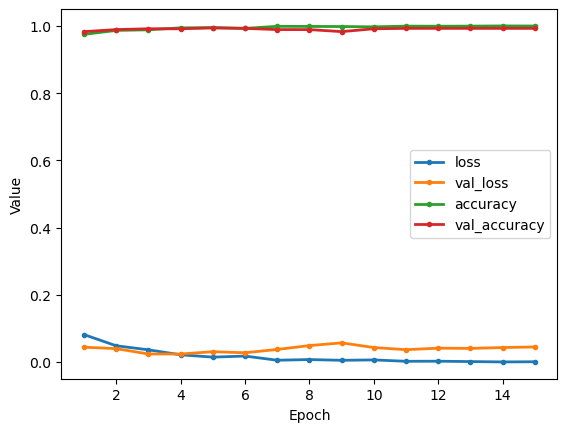

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1936,0.005291,0.0,0.0,0.000000,0.0,0.002646,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3604,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.002288,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,0.007595,0.0,0.0,0.002532,0.0,0.002532,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.001011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4122, 8734)
X_test: (1031, 8734)
y_train: (4122,)
y_test: (1031,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,236,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,279,425 (8.70 MB)

 Trainable params: 2,279,425 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 24s 472ms/step - accuracy: 0.5312 - loss: 0.6931

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5127 - loss: 0.6916   

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5460 - loss: 0.6874

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5973 - loss: 0.6777

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6409 - loss: 0.6606

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6764 - loss: 0.6362

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6992 - loss: 0.6144 - val_accuracy: 0.9842 - val_loss: 0.0623


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0581

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9859 - loss: 0.0582 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9874 - loss: 0.0535

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0496

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.0472

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.0454

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9891 - loss: 0.0439 - val_accuracy: 0.9927 - val_loss: 0.0247


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0056

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0042 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0106

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0123

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0128

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0126

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0123 - val_accuracy: 0.9988 - val_loss: 0.0063


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0014

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9988 - val_loss: 0.0053


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.8075e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5948e-04 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3932e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9751e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0092e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8585e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7453e-04 - val_accuracy: 0.9964 - val_loss: 0.0092


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.9063e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6383e-04 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9420e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5683e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2393e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9603e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7704e-04 - val_accuracy: 0.9988 - val_loss: 0.0073


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.2071e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3296e-04 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2714e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1940e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2460e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3461e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3829e-04 - val_accuracy: 0.9988 - val_loss: 0.0061


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.0554e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2744e-04 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9973e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8285e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7051e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6076e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5576e-04 - val_accuracy: 0.9976 - val_loss: 0.0092


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1654e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4108e-05 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5456e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0616e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1030e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1248e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1326e-04 - val_accuracy: 0.9988 - val_loss: 0.0071


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.1382e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7066e-05 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3469e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6211e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8568e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3890e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6838e-05 - val_accuracy: 0.9976 - val_loss: 0.0097


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.8266e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6957e-05 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8265e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0687e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8429e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1153e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3258e-05 - val_accuracy: 0.9988 - val_loss: 0.0037


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.7290e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9337e-04 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7643e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5862e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4346e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3184e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2449e-04 - val_accuracy: 0.9988 - val_loss: 0.0090


Epoch 13/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6965e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5592e-05 

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5432e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0620e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1664e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2128e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2215e-04 - val_accuracy: 0.9988 - val_loss: 0.0050



[Train Accuracy: 100.00% - Test Accuracy: 99.61%]


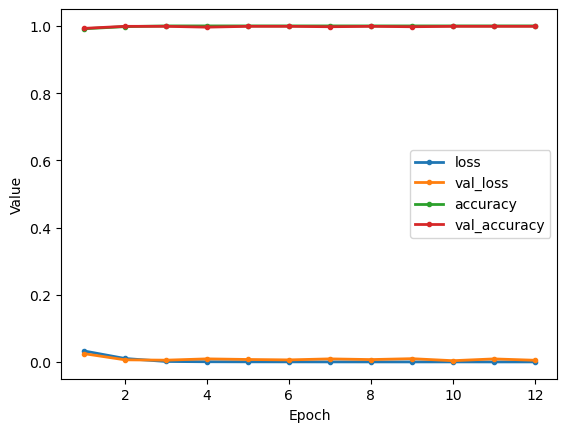

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1936,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3604,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,0.002538,0.0,0.0,0.0,0.0,0.002538,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3952,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,727,873 (136.29 MB)

 Trainable params: 35,727,873 (136.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 33s 658ms/step - accuracy: 0.5469 - loss: 0.6931

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5391 - loss: 0.6931 

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5330 - loss: 0.6930

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5335 - loss: 0.6929

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5331 - loss: 0.6928

 6/52 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5323 - loss: 0.6927

 7/52 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5315 - loss: 0.6926

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5293 - loss: 0.6925

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5280 - loss: 0.6923

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5280 - loss: 0.6922

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5280 - loss: 0.6920

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5306 - loss: 0.6918

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5349 - loss: 0.6916

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5405 - loss: 0.6914

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5468 - loss: 0.6911

16/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5532 - loss: 0.6908

17/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5599 - loss: 0.6905

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5668 - loss: 0.6901

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5737 - loss: 0.6898

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5805 - loss: 0.6894

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5872 - loss: 0.6890

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5939 - loss: 0.6885

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6005 - loss: 0.6881

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6069 - loss: 0.6875

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6132 - loss: 0.6869

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6193 - loss: 0.6863

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6252 - loss: 0.6857

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6310 - loss: 0.6849

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6366 - loss: 0.6842

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6420 - loss: 0.6833

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6473 - loss: 0.6824

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6524 - loss: 0.6815

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6574 - loss: 0.6805

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6622 - loss: 0.6794

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6669 - loss: 0.6782

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6715 - loss: 0.6770

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6759 - loss: 0.6757

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6801 - loss: 0.6744

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6843 - loss: 0.6730

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6883 - loss: 0.6715

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6922 - loss: 0.6699

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6960 - loss: 0.6683

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6996 - loss: 0.6666

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7032 - loss: 0.6649

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7066 - loss: 0.6631

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7100 - loss: 0.6612

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7132 - loss: 0.6593

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7164 - loss: 0.6573

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7194 - loss: 0.6553

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7224 - loss: 0.6531

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7253 - loss: 0.6509

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7281 - loss: 0.6487

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.7308 - loss: 0.6466 - val_accuracy: 0.9685 - val_loss: 0.1445


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9844 - loss: 0.1484

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9883 - loss: 0.1382

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9887 - loss: 0.1325

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9867 - loss: 0.1300

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9862 - loss: 0.1262

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9863 - loss: 0.1226

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9867 - loss: 0.1189

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9871 - loss: 0.1154

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9874 - loss: 0.1123

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9877 - loss: 0.1094

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9881 - loss: 0.1066

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9884 - loss: 0.1040

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9887 - loss: 0.1015

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9891 - loss: 0.0991

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9894 - loss: 0.0969

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9897 - loss: 0.0948

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9899 - loss: 0.0928

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9901 - loss: 0.0909

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9903 - loss: 0.0890

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9905 - loss: 0.0874

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9906 - loss: 0.0858

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9908 - loss: 0.0843

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9909 - loss: 0.0828

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9910 - loss: 0.0814

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9912 - loss: 0.0801

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9913 - loss: 0.0788

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9914 - loss: 0.0776

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9914 - loss: 0.0765

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9915 - loss: 0.0754

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9916 - loss: 0.0744

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9916 - loss: 0.0734

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9917 - loss: 0.0725

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9917 - loss: 0.0716

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9918 - loss: 0.0708

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9918 - loss: 0.0699

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9919 - loss: 0.0691

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9919 - loss: 0.0684

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9920 - loss: 0.0677

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9920 - loss: 0.0670

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9921 - loss: 0.0663

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9921 - loss: 0.0657

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9921 - loss: 0.0650

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9922 - loss: 0.0644

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9922 - loss: 0.0638

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9923 - loss: 0.0632

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9923 - loss: 0.0626

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9924 - loss: 0.0621

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9924 - loss: 0.0615

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9924 - loss: 0.0610

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.0604

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.0599

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9925 - loss: 0.0594

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9926 - loss: 0.0589 - val_accuracy: 0.9903 - val_loss: 0.0282


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0043

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0038

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0035

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0033

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0033

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0033

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9997 - loss: 0.0036

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9995 - loss: 0.0038

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9993 - loss: 0.0039

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9993 - loss: 0.0040

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9992 - loss: 0.0040

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9991 - loss: 0.0040

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9991 - loss: 0.0041

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9991 - loss: 0.0041

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9991 - loss: 0.0041

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9991 - loss: 0.0041

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9991 - loss: 0.0041

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9991 - loss: 0.0041

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9991 - loss: 0.0041

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9991 - loss: 0.0040

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9991 - loss: 0.0040

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9991 - loss: 0.0040

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9991 - loss: 0.0040

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9991 - loss: 0.0040

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9991 - loss: 0.0039

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0039

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0039

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0039

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0038

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0038

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9992 - loss: 0.0038

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9992 - loss: 0.0038

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0038

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0037

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9992 - loss: 0.0037

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9993 - loss: 0.0037

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9993 - loss: 0.0037

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9993 - loss: 0.0037

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9993 - loss: 0.0036

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9993 - loss: 0.0036

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9993 - loss: 0.0036

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9993 - loss: 0.0036

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9993 - loss: 0.0036

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9993 - loss: 0.0036

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9993 - loss: 0.0035

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0035

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0035

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0035

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9994 - loss: 0.0035

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9994 - loss: 0.0035

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9994 - loss: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9994 - loss: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9891 - val_loss: 0.0281


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 0.0011

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0011

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0011

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0010

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0010

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 9.9909e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 9.8717e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 9.7102e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.8025e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 9.8395e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0010    

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0010

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0010

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0011

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0011

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0011

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0011

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0011

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0011

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0011

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0011

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0011

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0011

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 0.0011

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0011

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 0.0011

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0011

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0011

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0010

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0010

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0010

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0010

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0010

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9879 - val_loss: 0.0324


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 1.0000 - loss: 5.3221e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 5.3932e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 5.3656e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 5.2813e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 5.2195e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 5.2704e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 5.3715e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.3968e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.4155e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.4195e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.4096e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.3921e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.3742e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.3556e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.3363e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.3105e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.2803e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.2531e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.2219e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.1887e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.1565e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.1227e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 5.1043e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.0888e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.0708e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.0511e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.0296e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.0077e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.9856e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.9619e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.9392e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.9173e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.8954e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.8731e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.8521e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.8324e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.8127e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7934e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7752e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 4.7582e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 4.7422e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 4.7264e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 4.7098e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 4.6926e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 4.6757e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 4.6590e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 4.6425e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 4.6258e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 4.6113e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 4.5974e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 4.5839e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 4.5723e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.5612e-04 - val_accuracy: 0.9879 - val_loss: 0.0354


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 1.0000 - loss: 3.9385e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 3.5215e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.1958e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.9418e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 2.8986e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.8982e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.9417e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.9639e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.9909e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.0002e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.9986e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 3.0032e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.9991e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.9868e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.9705e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.9545e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.9370e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.9196e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.9012e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.8817e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.8621e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.8452e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.8311e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 2.8170e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 2.8031e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7895e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7755e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7612e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7473e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7351e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7409e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7457e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.7493e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.7526e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.7547e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7559e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7561e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7559e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.7547e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.7530e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.7507e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 2.7479e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7444e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 2.7406e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7362e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7321e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7276e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7234e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7193e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7148e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.7102e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.7056e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 2.7013e-04 - val_accuracy: 0.9903 - val_loss: 0.0317


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.6086e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 1.0000 - loss: 1.6277e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.6605e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.6746e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 1.6737e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.6637e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.6874e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7210e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7388e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7630e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.7811e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7902e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7918e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.7916e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.7891e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7851e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7844e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7842e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7888e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7913e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.7939e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.8013e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.8067e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.8097e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.8135e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.8169e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.8191e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.8312e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.8410e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.8501e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.8577e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.8643e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.8700e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.8749e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.8786e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.8820e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.8844e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.8861e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.8871e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.8873e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.8870e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.8863e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.8857e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.8847e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8835e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8818e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.8798e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8776e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8749e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8720e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8691e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.8667e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 1.8644e-04 - val_accuracy: 0.9903 - val_loss: 0.0347


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 9.3658e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 9.3671e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 1.0739e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 1.2289e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 1.4717e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 1.5868e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 1.6453e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.6802e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.6944e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7146e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7240e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7280e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7234e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7221e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7179e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7107e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.7031e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.6928e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.6812e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.6718e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.6627e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.6536e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.6446e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.6367e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.6315e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6255e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.6205e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.6150e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.6098e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.6048e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5991e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5937e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5879e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5819e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5762e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5700e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5639e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5581e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5521e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.5460e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5396e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5334e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5272e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.5209e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5146e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5081e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.5016e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.4951e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.4885e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.4820e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.4755e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 1.4691e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 1.4629e-04 - val_accuracy: 0.9903 - val_loss: 0.0353


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 1.2815e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 1.2651e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 1.2512e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 1.0000 - loss: 1.3055e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 1.0000 - loss: 1.3148e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.2937e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.2846e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.2726e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.2565e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.2375e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.2170e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.1978e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.1798e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.1636e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.1482e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.1339e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.1191e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.1048e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.1208e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1339e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.1513e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1657e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.1769e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.1857e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1932e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.2005e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.2057e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2094e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2120e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2140e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2149e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2154e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2153e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2146e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2134e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2118e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.2103e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.2084e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.2060e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.2034e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.2007e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1978e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.1949e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1924e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1897e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1870e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.1843e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1814e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1784e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1753e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.1723e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.1694e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.1665e-04 - val_accuracy: 0.9903 - val_loss: 0.0371


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 1.0000 - loss: 2.4732e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.0201e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.1167e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.2694e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 3.4252e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.5582e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.6525e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 3.7264e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.7973e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.8734e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.9307e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.9774e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.0088e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.0460e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.0752e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.0922e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 4.1310e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.1590e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.1850e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.2044e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.2188e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.2347e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.2501e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.2625e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 4.2757e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.2864e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.3011e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.3134e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.3247e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.3344e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.3594e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.4260e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.4873e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 4.5465e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.6027e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.6542e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.7016e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.7451e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.7854e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.8281e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.8676e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.9037e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 4.9358e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.9665e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 4.9952e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.0233e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.0519e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.0790e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.1030e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.1258e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.1465e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.1658e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 5.1844e-05 - val_accuracy: 0.9903 - val_loss: 0.0357


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.7614e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 4.6237e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 5.0526e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 5.3000e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 5.3057e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 5.3170e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 5.2550e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 5.1825e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 5.2371e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.2583e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 5.2643e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.2978e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.3468e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.3747e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.4063e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.4253e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4491e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4608e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4639e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4685e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.4645e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.4592e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4497e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4409e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.4297e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4189e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4066e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4109e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4276e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4598e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.4952e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5260e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5515e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5737e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.5932e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 5.6083e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 5.6220e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 5.6327e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.6429e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.6512e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.6571e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.6637e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.6686e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.6775e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.6902e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7015e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7114e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7196e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7264e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7313e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 5.7354e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7386e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 5.7416e-05 - val_accuracy: 0.9903 - val_loss: 0.0403


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.5128e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 3.7977e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 1.0000 - loss: 4.0228e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 1.0000 - loss: 3.9406e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 3.8570e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.9022e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.9814e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 4.0823e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.1421e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.1727e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.2178e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.2428e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.2520e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.2591e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.2836e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.2990e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.3036e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.2995e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.2883e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.2800e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 4.2810e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 4.2763e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.2675e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 4.2642e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.2577e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.2487e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.2385e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.2252e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.2102e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.1970e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.1831e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.1683e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.1540e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.1387e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.1238e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.1095e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.0945e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0792e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0640e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0489e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0351e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0209e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0063e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.9911e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9764e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9617e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9474e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.9336e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.9195e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.9060e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.8933e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 3.8815e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8701e-05 - val_accuracy: 0.9903 - val_loss: 0.0413



[Train Accuracy: 100.00% - Test Accuracy: 99.42%]


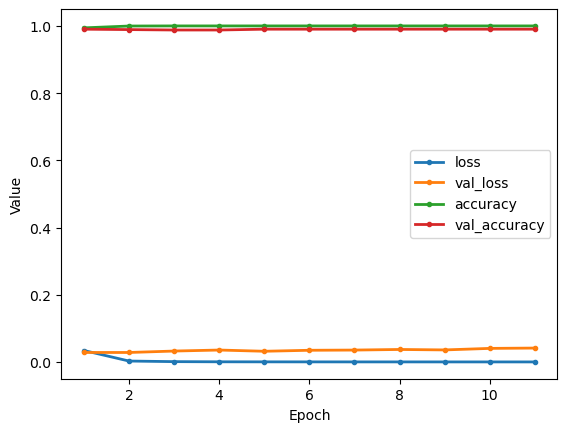

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [25]:
report.save()

Report saved as Output/Reports/ZF-HD/report_O16OTA6D.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################